In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2.5e4: age_factor = 0.5
else: age_factor = 1.05

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.random() for _ in cards_to_age.index]

cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure AI Foundry,38.795681,7.759136,5
IW Migration,44.135107,1.576254,28
Email Auth and Security,108.376918,4.335077,25
Developer Mode,139.202655,69.601328,2
General,275.480551,68.870138,4
Jane Eyre,305.471738,30.547174,10
Workera.ai,328.244375,65.648875,5
Git,336.805999,67.361200,5
Dataverse,355.654435,71.130887,5
Diffusers Documentation,357.967679,71.593536,5


18671.648512863056


<Axes: >

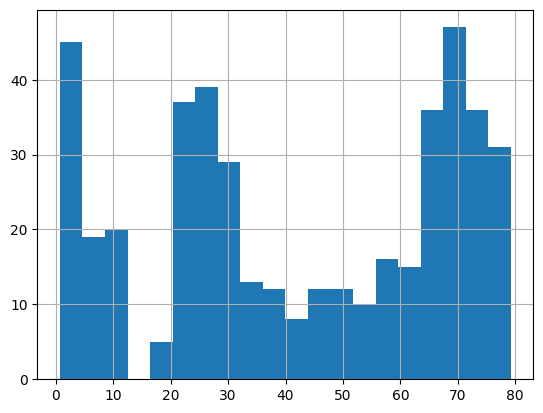

In [23]:
print(existing_cards['age'].sum())
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [24]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Shuffle

In [25]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

In [26]:
existing_cards[['head', 'age']].head(n = 10)

,head,age
0,sklearn,78.164947
1,Email Auth and Security,4.724102
2,IW Migration,1.718393
3,Home Network Project,23.157077
4,Conditional Access,66.399812
5,Git,61.467912
6,Conditional Access,70.997833
7,Search Engine Optimization,33.659792
8,Search Engine Optimization,34.013798
9,IW Migration,1.865128


# Headers with fewest notes first

In [27]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['oldest'] *= -1

# existing_cards.sort_values(['frequency', 'oldest', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

In [28]:
existing_cards['head'].value_counts()

head
Home Network Project              43
Azure Kubernetes Learning Path    43
DNS                               36
IW Migration                      28
Email Auth and Security           25
Search Engine Optimization        25
Python                            21
sklearn                           20
Azure Functions                   18
PP365                             18
OData                             17
Diffusers Library                 16
Power BI                          11
MS Identity Platform              11
Kali Linux                        10
Jane Eyre                         10
Diffusers from Hugging Face       10
AKS                                8
pandas                             8
Conditional Access                 7
Dataverse Plugins                  7
Dataverse Queries                  7
Azure OpenAI                       6
Azure AI Search                    6
Dataverse                          5
Workera.ai                         5
Git                              

# Focus on one header

In [29]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# one_header = 'Diffusers Library'
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [30]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [31]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [32]:
existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
remake_card_document(existing_cards)

Cards found: 442


In [33]:
112e3/165

678.7878787878788